# Spike maps with `geopandas` and `matplotlib`
* Data: Covid-19 confirmed cases & deaths in Connecticut (data by CT Department of Public Health)
* Inspired NYTimes Covid-19 reporting & Giuseppe Sollazzo's SpikesMap https://github.com/puntofisso/SpikesMap

In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt

from shapely.geometry import shape

### Get confirmed cases & deaths counts by town
* Read data from Socrata
* Filter to get the most recent day
* Make sure it's the same date for all towns

In [22]:
# Read Covid-19 data from Socrata
raw = pd.read_json(
    f'https://data.ct.gov/resource/28fr-iqnx.json?$limit=10000000000',
    convert_dates=['lastupdatedate']
)

# Get the most recent record for each town
data = raw.loc[raw.groupby(['town'])['lastupdatedate'].idxmax()]

# Make sure the most recent date is the same for all towns
assert len(data.lastupdatedate.unique()) == 1, ''

data.head()

,town_no,town,lastupdatedate,confirmedcases,deaths
3718,1,Andover,2020-04-15,1,0
3719,2,Ansonia,2020-04-15,94,0
3720,3,Ashford,2020-04-15,4,0
3721,4,Avon,2020-04-15,23,2
3722,5,Barkhamsted,2020-04-15,8,0


### Get Connecticut town boundaries and simplify geometry
* The original GeoJSON is too heavy (2Mb), so simplify
* Transform projection to Web Mercator

In [23]:
# Read CT town boundaries files from Socrata
geo = gpd.read_file('https://data.ct.gov/api/geospatial/w7gh-9eke?method=export&format=GeoJSON')

# Simplify geometry to make output SVGs smaller
geo.geometry = geo.geometry.simplify(0.0025)

# Convert CRS to the more common Web Mercator
geo = geo.to_crs(epsg=3857)

### Combine data + geo, calculate centroids for towns
* Calculate centroids for each town with `shapely`
* Hamden and New Haven are on a similar longitude, so move them apart manually

In [24]:
# Combine data + geo into a single dataframe
geo_data = geo.merge(
    data,
    how='inner',
    left_on='town',
    right_on='town'
).set_index(['name'])

assert geo_data.shape[0] == 169, 'Did not get 169 rows after join'

# Calculate a centroid for each town boundary
geo_data['centroid'] = geo_data.geometry.apply(
    lambda x: shape(x).centroid.coords[0]
)

# Manually adjust centroids for Hamden and New Havens to avoid overlap
hamden_x, hamden_y = geo_data.at['Hamden', 'centroid']
geo_data.at['Hamden', 'centroid'] = (hamden_x - 2000, hamden_y - 2000)

newhaven_x, newhaven_y = geo_data.at['New Haven', 'centroid']
geo_data.at['New Haven', 'centroid'] = (newhaven_x + 2000, newhaven_y + 2000)

### Define a function to draw spikes (triangles) & basic label styles

In [25]:
def create_triangle(x, y, height, base=1000, color='black'):
    """ Returns a triangle polygon whose middle of base is located at (x,y) """
    return plt.Polygon(
        [[x-base, y], [x, y+height], [x+base, y]],
        color=color,
        fill=True
    )


# Label styles that are the same for all labels
label_styles = dict(
    horizontalalignment='center',
    fontfamily='Helvetica',
    linespacing=0.8,
    path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()]
)

# Keep the variable to use in filename
last_update_date = geo_data.iloc[0].lastupdatedate.strftime("%Y-%m-%d")

### Generate Deaths map with labels

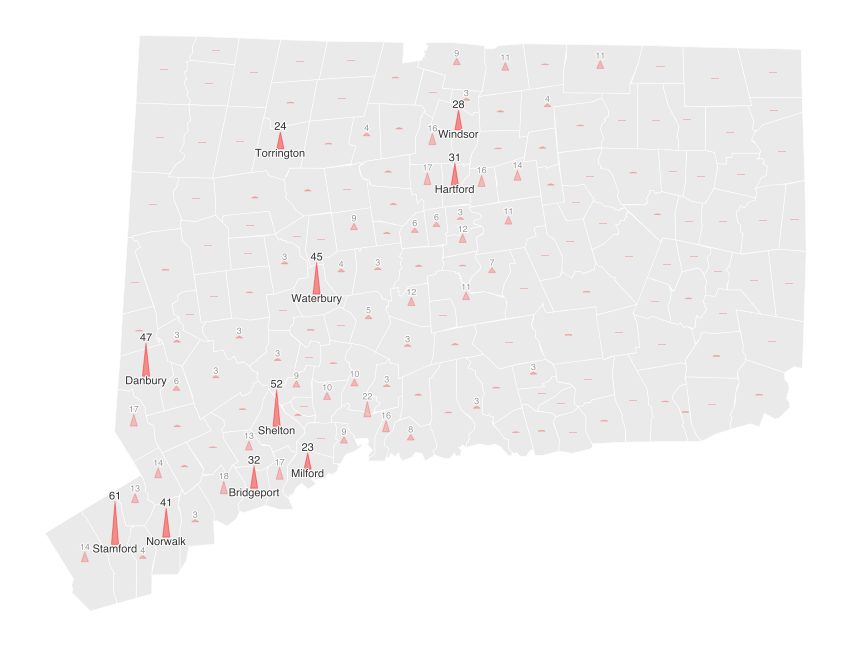

In [26]:
ax = geo_data.plot(
    figsize=(15, 15),
    color='#eaeaea',
    edgecolor='white',
    linewidth=0.6
)
ax.axis('off')

# Towns with labels are those with top-10 deaths
towns_w_labels = geo_data['deaths'].nlargest(10).index.tolist()

# Coefficient for spike height
multiplier = 200

# Add spikes & labels
for i, row in geo_data.iterrows():
    x, y = row.centroid

    # Create a spike
    triangle = create_triangle(
        x,
        y,
        height=row.deaths * multiplier,
        color=(1, 0, 0, 0.4) if row.town in towns_w_labels else (1, 0, 0, 0.2)
    )
    ax.add_patch(triangle)

    # Add town labels
    if row.town in towns_w_labels:
        ax.text(
            x,
            y,
            row.town.replace(' ', '\n'),
            color=(0, 0, 0, 0.8),
            fontsize=11,
            verticalalignment='top',
            **label_styles
        )

    # Create numbers labels for top-10
    if row.town in towns_w_labels:
        ax.text(
            x,
            y + row.deaths * multiplier,
            row.deaths,
            color=(0, 0, 0, 0.8),
            fontsize=11,
            verticalalignment='bottom',
            **label_styles
        )

    # Create lighter numbers with 3 or more deaths
    if row.deaths >= 3 and row.town not in towns_w_labels:
        ax.text(
            x,
            y + row.deaths*multiplier,
            row.deaths,
            color=(0, 0, 0, 0.4),
            fontsize=9,
            verticalalignment='bottom',
            **label_styles
        )


plt.savefig(f'output/{last_update_date}-deaths.svg', bbox_inches='tight')

### Generate Confirmed Cases map with labels

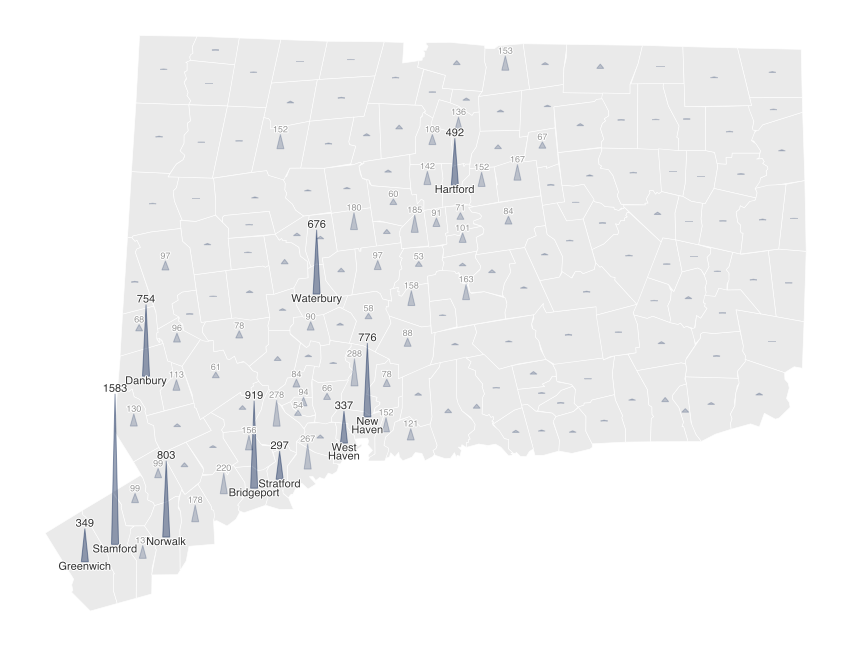

In [27]:
ax = geo_data.plot(
    figsize=(15, 15),
    color='#eaeaea',
    edgecolor='white',
    linewidth=0.6
)
ax.axis('off')

# Towns with labels are those with top-10 confirmed cases
towns_w_labels = geo_data['confirmedcases'].nlargest(10).index.tolist()

# Coefficient for spike height
multiplier = 27

# Add spikes and labels
for i, row in geo_data.iterrows():
    x, y = row.centroid

    # Add a spike
    triangle = create_triangle(
        x, y,
        height=row.confirmedcases*multiplier,
        # Triangles more transparent for towns with fewer cases
        color=(0, 0.1, 0.3, 0.4) if row.town in towns_w_labels else (0, 0.1, 0.3, 0.2)
    )
    ax.add_patch(triangle)

    # Add town labels
    if row.town in towns_w_labels:
        ax.text(
            x,
            y,
            row.town.replace(' ', '\n'),
            color=(0, 0, 0, 0.8),
            fontsize=11,
            verticalalignment='top',
            **label_styles
        )

    # Create numbers labels for top-10
    if row.town in towns_w_labels:
        ax.text(
            x,
            y + row.confirmedcases * multiplier,
            row.confirmedcases,
            color=(0, 0, 0, 0.8),
            fontsize=11,
            verticalalignment='bottom',
            **label_styles
        )

    # Create lighter numbers where over 50 cases
    if row.confirmedcases > 50 and row.town not in towns_w_labels:
        ax.text(
            x,
            y + row.confirmedcases * multiplier,
            row.confirmedcases,
            color=(0, 0, 0, 0.4),
            fontsize=9,
            verticalalignment='bottom',
            **label_styles
        )

plt.savefig(f'output/{last_update_date}-cases.svg', bbox_inches='tight')

In [28]:
f'Confirmed cases: {geo_data["confirmedcases"].sum()}'

'Confirmed cases: 14218'

In [29]:
f'Deaths: {geo_data["deaths"].sum()}'

'Deaths: 866'